<a href=https://keras.io/examples/vision/conv_lstm/>LSTM</a><br>
<a href=https://stanford.edu/%7Eshervine/blog/keras-how-to-generate-data-on-the-fly>Dataset Class</a>

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from data import DataGenerator
import matplotlib.pyplot as plt
import os

2023-08-06 16:04:31.508960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.571909, nms_thresh=0.3.


## Test Stardist

In [2]:
from stardist.models import StarDist2D
from lamprogen.recipes.dl import stardist_2d_slicewise
import tifffile as tiff

modeldir = f'models'
name = 'lamprogen-stardist-trained'
model = StarDist2D(None, name=name,basedir=modeldir)

im = tiff.imread('data/images/230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif')
labeled_3d = stardist_2d_slicewise(im, model)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.571909, nms_thresh=0.3.


In [13]:
from skimage.io import imsave

for image in images:
  path = 'data/images/'+image
  im = tiff.imread(path)
  labeled_3d = stardist_2d_slicewise(im, model)
  imsave('data/inputs/'+image, labeled_3d)

2405117065.py (7): data/inputs/230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif is a low contrast image
2405117065.py (7): data/inputs/230413 GLA HEX grad post v2_Plate_1081_well_D02_channel2_0.tif is a low contrast image
2405117065.py (7): data/inputs/230413 GLA HEX grad post v2_Plate_1081_well_D03_channel2_0.tif is a low contrast image
2405117065.py (7): data/inputs/230413 GLA HEX grad post v2_Plate_1081_well_D03_channel2_1.tif is a low contrast image
2405117065.py (7): data/inputs/230413 GLA HEX grad post v2_Plate_1081_well_D05_channel2_0.tif is a low contrast image


In [12]:
import napari

im = tiff.imread('data/inputs/230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif')
mask = tiff.imread('data/masks/230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif')
viewer=napari.Viewer()

viewer.add_image(im, name='intensity')
viewer.add_labels(labeled_3d, name='labels')

<Labels layer 'labels' at 0x7fe99674e9b0>

## Define Dataset

In [2]:
import tifffile as tiff
image = tiff.imread("data/masks/230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif")
image.shape

(70, 256, 256)

In [3]:
def get_ids(path='data'):
    images = []
    masks = []
    for file in os.listdir(path+'/inputs'):
        images.append(file)

    for file in os.listdir(path+'/masks'):
        masks.append(file)

    return images, masks

images, masks = get_ids()
images.sort()
masks.sort()
images = images[:5]
masks = images[:5]

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1)

In [4]:
print(X_train[3])
print(y_train[3])
print(X_test[0])
print(y_test[0])

230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif
230413 GLA HEX grad post v2 last well_Plate_1082_well_D12_channel2_1.tif
230413 GLA HEX grad post v2_Plate_1081_well_D03_channel2_1.tif
230413 GLA HEX grad post v2_Plate_1081_well_D03_channel2_1.tif


In [5]:
params = {'dim': (70,256,256),
          'batch_size': 2,
          'n_channels': 3,
          'shuffle': True}


training_generator = DataGenerator(X_train, y_train, **params)
validation_generator = DataGenerator(X_test, y_test, **params)

In [6]:
print(training_generator[0][0].shape)
type(training_generator)

(2, 70, 256, 256, 3)


data.DataGenerator

In [18]:
image[0].shape

(256, 256, 3)

Displaying frames for example 0.


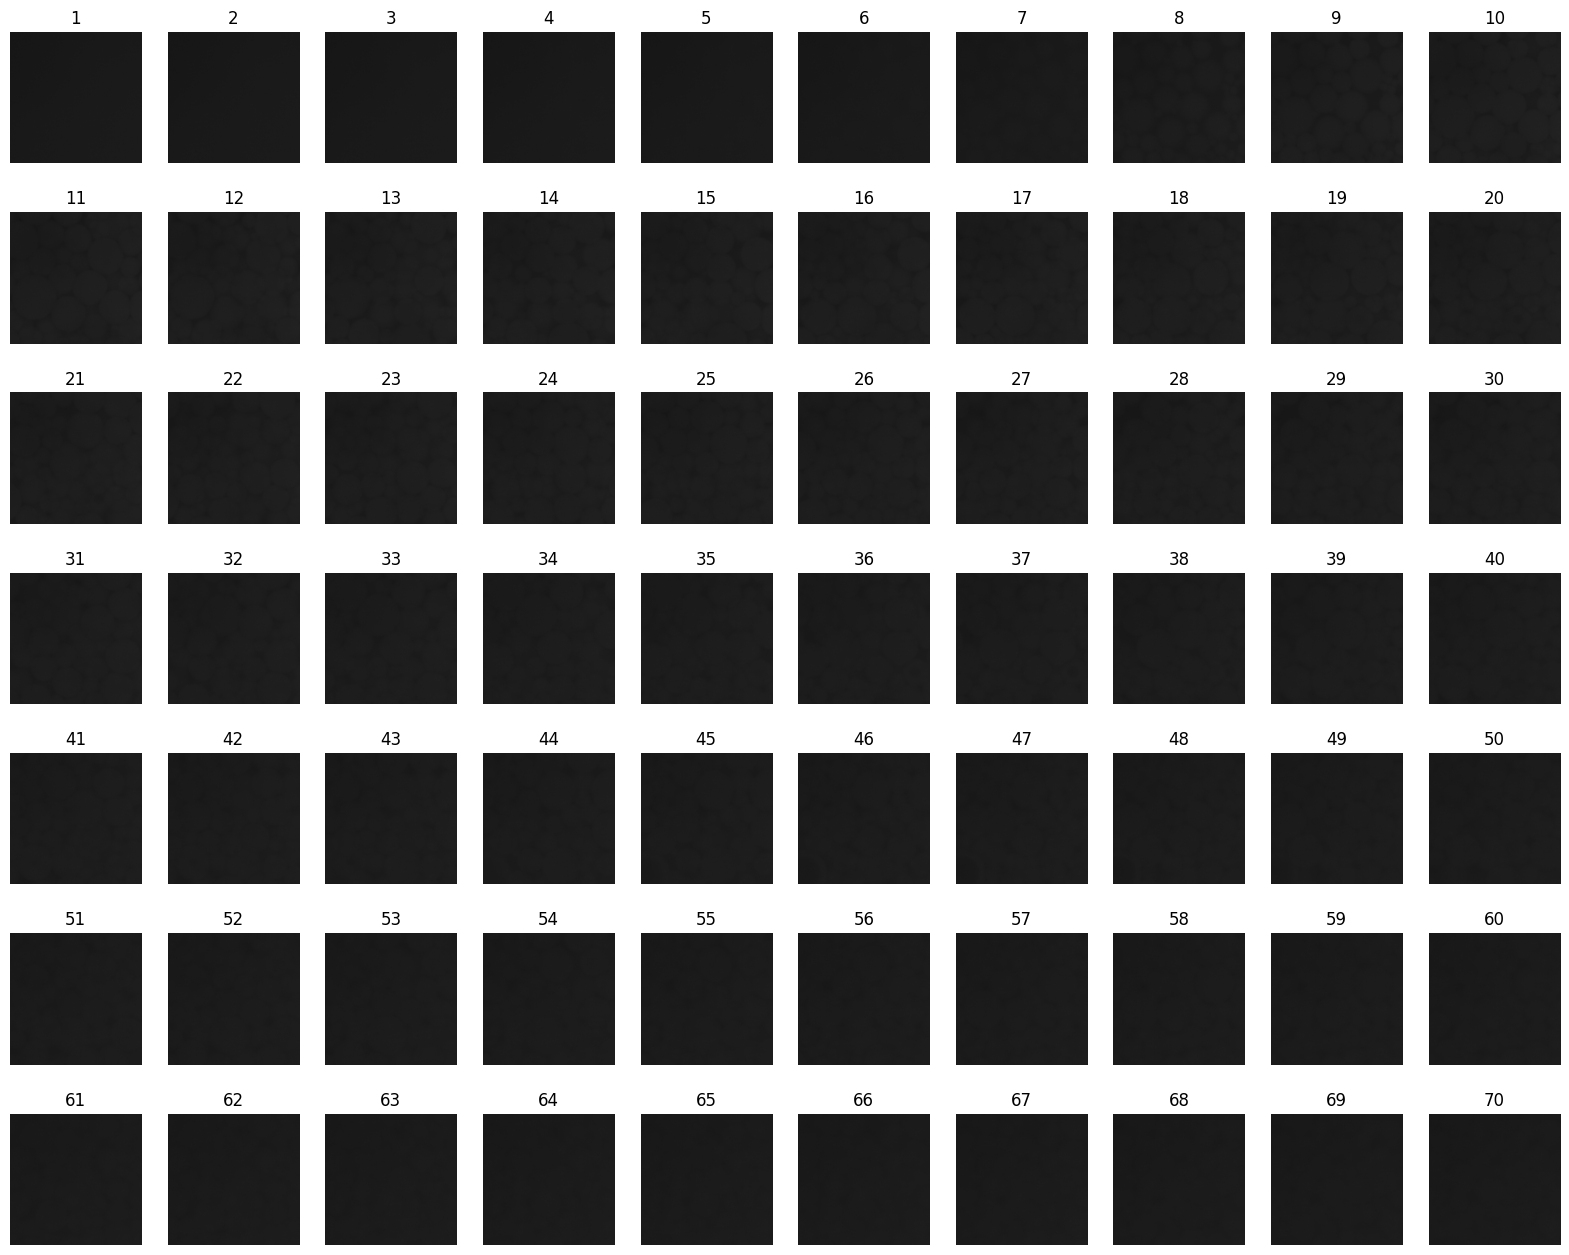

In [25]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(7, 10, figsize=(20, 16))

# Plot each of the sequential images for one random data example.
image = training_generator[0][0][0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(image[idx].astype('uint8')), cmap="magma")
    ax.set_title(f"{idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {0}.")
plt.show()

## Define Model

In [26]:
#Load Packages
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization

model = Sequential()

model.add(ConvLSTM2D(filters=3, kernel_size=(3, 3),
                   input_shape=(70, 256, 256, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
model.compile(loss='binary_crossentropy', optimizer='adadelta')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 70, 256, 256, 3)   660       
                                                                 
 batch_normalization (Batch  (None, 70, 256, 256, 3)   12        
 Normalization)                                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 70, 256, 256, 40   62080     
                             )                                   
                                                                 
 batch_normalization_1 (Bat  (None, 70, 256, 256, 40   160       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 70, 256, 256, 40   115360    
                             )                          

## Define Traing Loop

In [28]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 2
batch_size = 5

checkpoint_path = "LSTM Training"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Fit the model to the training data.
model.fit(
    training_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, cp_callback],
)

Epoch 1/2
